In [13]:
import sys
sys.path.append('./lib/RAFT/core')

In [14]:
import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

from classes.video import Video
import skvideo.io

In [15]:
DEVICE = 'cuda'

def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)


def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().numpy()
    flo = flo[0].permute(1,2,0).cpu().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    # import matplotlib.pyplot as plt
    plt.imshow(img_flo / 255.0)
    plt.show()

#     cv2.imshow('image', img_flo[:, :, [2,1,0]]/255.0)
#     cv2.waitKey()

In [16]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
# parser.add_argument('--path', help="dataset for evaluation")
# parser.add_argument('--video', help="video for test")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
# args = parser.parse_args("--model lib/RAFT/models/raft-things.pth --path lib/RAFT/demo-frames".split())
args = parser.parse_args("--model lib/RAFT/models/raft-small.pth --small".split())
args.model

'lib/RAFT/models/raft-small.pth'

In [17]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))

model = model.module
model.to(DEVICE)
model.eval()

print("Load model")

Load model


In [18]:
video = Video("videos/test/182.mp4")
video.check()
video.init_frames(sample_time_interval=0.125)

[META] Scikit-Video 182.mp4 1280x720 50fps h264
[META] Scikit-Video video-WQ6Ls4DogI.mp4 1280x720 50fps h264


In [20]:
def resize_frame(frame, target_width=0, target_height=0):
    (height, width, channels) = frame.shape
    if target_width == 0 and target_height == 0:
        return frame
    elif target_width == 0:
        target_width = int(width * target_height / height)
    elif target_height == 0:
        target_height = int(height * target_width / width)
    print(height, width, target_height, target_width)
    return cv2.resize(frame, (target_width, target_height), interpolation=cv2.INTER_AREA)

from skimage.measure import block_reduce
import math

def flow_extraction(flow, height_grid_num=12):
    (height, width, vector) = flow.shape
    grid_height = int(height / height_grid_num)
    grid_width = grid_height
    width_grid_num = math.ceil(width / grid_width)
    grid_width = int(width / width_grid_num)
    print(grid_height, grid_width, height_grid_num, width_grid_num)
    flow_ext = block_reduce(flow, block_size=(grid_height, grid_width, 1), func=np.mean)
    return flow_ext

def show_flow(flow, prev_frame, cur_frame):
    flow = flow_viz.flow_to_image(flow)
    plt.figure(figsize=(12,4))
#     ax1 = plt.subplot(1,3,3)
#     plt.sca(ax1)
    plt.imshow(flow)
#     ax2 = plt.subplot(1,3,1)
#     plt.sca(ax2)
#     plt.imshow(prev_frame)
#     ax3 = plt.subplot(1,3,2)
#     plt.sca(ax3)
#     plt.imshow(cur_frame)
    plt.show()

def show_flow_ext(flow_ext):
#     flow_ext = flow_viz.flow_to_image(flow_ext)
    mag, ang = cv2.cartToPolar(flow_ext[..., 0], flow_ext[..., 1])
    (height, width, _) = flow_ext.shape
    hsv = np.zeros((height, width, 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    flow_ext = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    plt.imshow(flow_ext)
    plt.show()

In [30]:
def show_flow(flow, prev_frame, cur_frame):
#     flow = flow_viz.flow_to_image(flow)
    print(flow.shape)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    (height, width, _) = prev_frame.shape
    hsv = np.zeros((height, width, 3), dtype=np.uint8)
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
#     plt.figure(figsize=(12,4))
#     ax1 = plt.subplot(1,3,3)
#     plt.sca(ax1)
    plt.imshow(bgr)
#     ax2 = plt.subplot(1,3,1)
#     plt.sca(ax2)
#     plt.imshow(prev_frame, cmap ='gray')
#     ax3 = plt.subplot(1,3,2)
#     plt.sca(ax3)
#     plt.imshow(cur_frame, cmap ='gray')
    plt.show()

720 1280 720 1280
720 1280 720 1280
6
60 58 12 22
(720, 1280, 2)


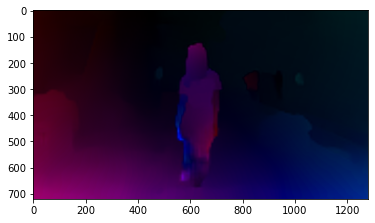

720 1280 720 1280
12
60 58 12 22
(720, 1280, 2)


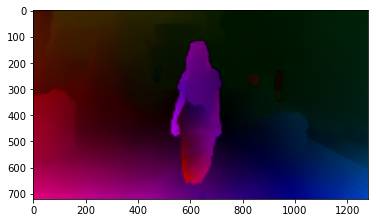

720 1280 720 1280
19
60 58 12 22
(720, 1280, 2)


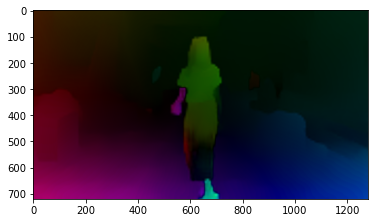

720 1280 720 1280
25
60 58 12 22
(720, 1280, 2)


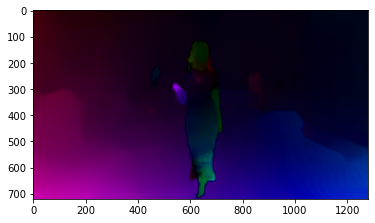

720 1280 720 1280
31
60 58 12 22
(720, 1280, 2)


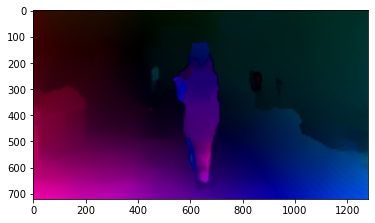

720 1280 720 1280
38
60 58 12 22
(720, 1280, 2)


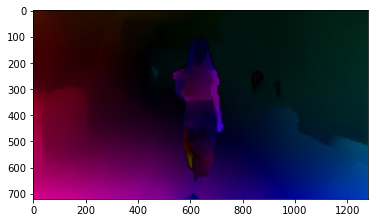

720 1280 720 1280
44
60 58 12 22
(720, 1280, 2)


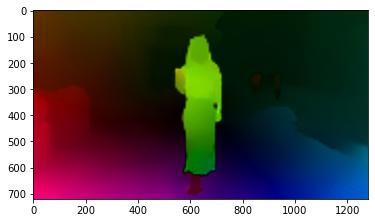

720 1280 720 1280
50
60 58 12 22
(720, 1280, 2)


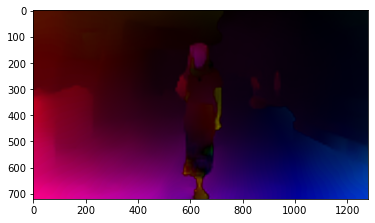

720 1280 720 1280
56
60 58 12 22
(720, 1280, 2)


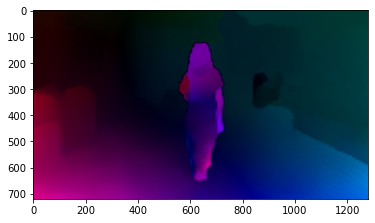

720 1280 720 1280
62
60 58 12 22
(720, 1280, 2)


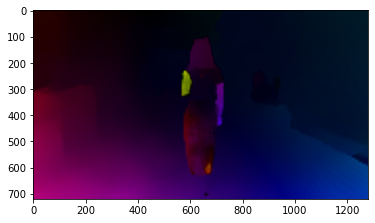

720 1280 720 1280
69
60 58 12 22
(720, 1280, 2)


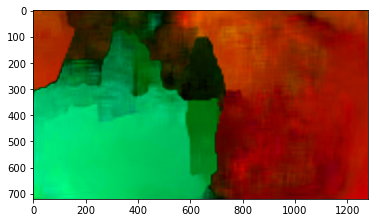

720 1280 720 1280
75
60 58 12 22
(720, 1280, 2)


KeyboardInterrupt: 

In [31]:
import time

with torch.no_grad():
    next_frame_number = 0
    video_frame_index = 0
    cap = skvideo.io.vreader(video.path, as_grey=False)
    prev_frame = None
    cur_frame = None
    start = time.time()
    for frame_number, frame in enumerate(cap):
        if prev_frame is None:
            frame = resize_frame(frame, 0, 720)
            prev_frame = torch.from_numpy(frame).permute(2, 0, 1).float()
            prev_frame = prev_frame[None].to(DEVICE)
            flow = np.zeros((frame.shape[0], frame.shape[1], 2))
    #         flow_ext = flow_extraction(flow)
    #         video.frames[video_frame_index].flow = flow_ext
            video_frame_index += 1
            next_frame_number = video.frames[video_frame_index].frame_number
        elif next_frame_number == frame_number:
            frame = resize_frame(frame, 0, 720)
            print(frame_number)
            cur_frame = torch.from_numpy(frame).permute(2, 0, 1).float()
            cur_frame = cur_frame[None].to(DEVICE)
            padder = InputPadder(prev_frame.shape)
            prev_f, cur_f = padder.pad(prev_frame, cur_frame)
            flow_low, flow_up = model(prev_f, cur_f, iters=20, test_mode=True)
            flow_up = flow_up[0].permute(1,2,0).cpu().numpy()
            flow_ext = flow_extraction(flow_up)
#             print(flow_up.shape)
#             viz(prev_f, flow_up)
            cur_f = cur_frame[0].permute(1,2,0).cpu().numpy() / 255.0
            prev_f = prev_frame[0].permute(1,2,0).cpu().numpy() / 255.0
            
#             print(cur_f.shape)
            show_flow(flow_up, prev_f, cur_f)
#             show_flow_ext(flow_ext)
    #         video.frames[video_frame_index].flow = flow_ext
    #         counts, bins = np.histogram(flow[..., 1], bins=5)
    #         plt.hist(bins[:-1], bins, weights=counts)
    #         plt.ylabel('count')
    #         plt.xlabel('x')
    #         plt.show()
            prev_frame = cur_frame
            video_frame_index += 1
            if video_frame_index >= len(video.frames):
                break
            next_frame_number = video.frames[video_frame_index].frame_number
    end = time.time()
    cost = end - start
    print('RAFT time cost:', cost)
    print('Frame per second:', video.frame_count / cost)

In [ ]:
import time
import skvideo.io
import progressbar
from skimage.measure import block_reduce
import math

parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
args = parser.parse_args("--model lib/RAFT/models/raft-small.pth --small".split())


def resize_frame(frame, target_width=0, target_height=0):
    (height, width, channels) = frame.shape
    if target_width == 0 and target_height == 0:
        return frame
    elif target_width == 0:
        target_width = int(width * target_height / height)
    elif target_height == 0:
        target_height = int(height * target_width / width)
    print(height, width, target_height, target_width)
    return cv2.resize(frame, (target_width, target_height), interpolation=cv2.INTER_AREA)


def flow_extraction(flow, height_grid_num=12):
    (height, width, vector) = flow.shape
    grid_height = int(height / height_grid_num)
    grid_width = grid_height
    width_grid_num = math.ceil(width / grid_width)
    grid_width = int(width / width_grid_num)
#     print(grid_height, grid_width, height_grid_num, width_grid_num)
    flow_ext = block_reduce(flow, block_size=(grid_height, grid_width, 1), func=np.mean)
    return flow_ext


def calc_flow_of_videos(videos):
    start = time.time()
    total_frame_count = sum([video.frame_count for video in videos])
#     temp_frame_count = 0
    model = torch.nn.DataParallel(RAFT(args))
    model.load_state_dict(torch.load(args.model))
    model = model.module
    model.to(DEVICE)
    model.eval()

    with torch.no_grad():
        p = progressbar.ProgressBar()
        p.start(len(videos))
        for vi, video in enumerate(videos):
            p.update(vi+1)
            fps = video.fps
            frame_interval = fps * video.sample_time_interval
            frame_interval = frame_interval if frame_interval >= 1 else 1
            frame_number = 0
            next_frame_number = 0
            frame_count = 0
            prev_frame = None
            cur_frame = None
            cap = skvideo.io.vreader(video.path)
            for frame_number, frame in enumerate(cap):
                if prev_frame is None:
                    frame = resize_frame(frame, 0, 720)
                    prev_frame = torch.from_numpy(frame).permute(2, 0, 1).float()
                    prev_frame = prev_frame[None].to(DEVICE)
                    flow = np.zeros((frame.shape[0], frame.shape[1], 2))
                    flow_ext = flow_extraction(flow)
                    video.frames[frame_count].flow = flow_ext
                    next_frame_number += frame_interval
                    frame_count += 1
                elif frame_number == int(round(next_frame_number)):
                    frame = resize_frame(frame, 0, 720)
#                     print(frame_number)
                    cur_frame = torch.from_numpy(frame).permute(2, 0, 1).float()
                    cur_frame = cur_frame[None].to(DEVICE)
                    padder = InputPadder(prev_frame.shape)
                    prev_f, cur_f = padder.pad(prev_frame, cur_frame)
                    flow_low, flow_up = model(prev_f, cur_f, iters=20, test_mode=True)
                    flow = flow_up[0].permute(1, 2, 0).cpu().numpy()
                    flow_ext = flow_extraction(flow)
                    video.frames[frame_count].flow = flow_ext
                    prev_frame = cur_frame
                    next_frame_number += frame_interval
                    frame_count += 1
    p.finish()
    end = time.time()
    cost = end - start
    print('RAFT time cost:', cost)
    print('Frame per second:', total_frame_count / cost)

In [ ]:
calc_flow_of_videos([video])

In [ ]:
for frame in video.frames:
    print(frame.frame_number)
    show_flow_ext(frame.flow)

In [98]:
path = "/taobao-0/shots/00.mp4"

In [2]:
import os
import pickle
def load_videos(folder, version):
    path = os.path.join(folder, 'videos-v{}.pkl'.format(version))
    with open(path, 'rb') as f:
        return pickle.load(f)
    raise IOError('No Video Data File', folder)

In [ ]:
videos = load_videos("templates/taobao-4", 5)
for video in videos:
    print(video.name)
    for frame in video.frames:
        print(frame.frame_number)
        print(frame.flow.shape)
        print(frame.roi)
        print(video.height, video.width)
        show_flow_ext(frame.flow)

In [151]:
def get_smooth_rois(video, start, end):
    w = video.width
    rois = np.array([(frame.roi[1]+frame.roi[3])/2/w for frame in video.frames[start:end]])
    rois = np.where(rois > 0.0, rois, 0.5)
    N = 7
    hN = N // 2
    weights = np.hanning(N)
    smooth_rois = np.convolve(weights/weights.sum(), rois, mode='full')[hN:-hN]
    smooth_rois[0:hN] = rois[0:hN]
    smooth_rois[-hN:] = rois[-hN:]
#     print(len(rois), len(smooth_rois))
#     plt.plot(rois)
#     plt.plot(smooth_rois)
#     plt.show()
    return smooth_rois


def get_mean_roi(video, start, end):
    rois = get_smooth_rois(video, start, end)
    return rois.mean()


def get_frame_flow(frame, mean_roi):
#     mean_roi = get_mean_roi(video)
    mid = math.floor(mean_roi * frame.flow.shape[1])
    if frame.flow.shape[1] <= 11:
        return (mid, frame.flow)
    if (mid - 5) < 0:
        start = 0
        end = start + 11
    elif (mid + 5) >= frame.flow.shape[1]:
        end = frame.flow.shape[1]
        start = end - 11
        mid = mid - start
    else:
        start = mid - 5
        end = mid + 5 + 1
        mid = mid - start
    return (mid, frame.flow[:, start:end])


def calc_flow_diff(frame1, frame2, mroi_1, mroi_2):
    v1_mid, v1_flow = get_frame_flow(frame1, mroi_1)
    v2_mid, v2_flow = get_frame_flow(frame2, mroi_2)
#     print(v1_mid, v1_flow.shape)
#     print(v2_mid, v2_flow.shape)
    if v1_flow.shape[1] < v2_flow.shape[1]:
        radius = v1_flow.shape[1] // 2
        if (v2_mid - radius) < 0:
            v2_start = 0
            v2_end = v2_start + v1_flow.shape[1]
        elif (v2_mid + radius) >= v2_flow.shape[1]:
            v2_end = v2_flow.shape[1]
            v2_start = v2_end - v1_flow.shape[1]
        else:
            v2_start = v2_mid - radius
            v2_end = v2_start + v1_flow.shape[1]
        v2_flow = v2_flow[:, v2_start:v2_end]
#         print("New v2_flow:", v2_start, v2_end)
    elif v1_flow.shape[1] > v2_flow.shape[1]:
        radius = v2_flow.shape[1] // 2
        if (v1_mid - radius) < 0:
            v1_start = 0
            v1_end = v1_start + v2_flow.shape[1]
        elif (v1_mid + radius) >= v1_flow.shape[1]:
            v1_end = v1_flow.shape[1]
            v1_start = v1_end - v2_flow.shape[1]
        else:
            v1_start = v1_mid - radius
            v1_end = v1_start + v2_flow.shape[1]
        v1_flow = v1_flow[:, v1_start:v1_end]
#         print("New v1_flow:", v1_start, v1_end)
    x_diff = v1_flow[:,:,0] - v2_flow[:,:,0]
    y_diff = v1_flow[:,:,1] - v2_flow[:,:,1]
    diff = np.mean(np.sqrt((x_diff * x_diff + y_diff * y_diff)))
    return diff

In [153]:
def calc_video_min_flow_diff(video1, video2):
    v1_frames = video1.frames
    v2_frames = video2.frames
    swap = len(v1_frames) < len(v2_frames)
    if swap:
        v1_frames, v2_frames = v2_frames, v1_frames
        video1, video2 = video2, video1
    min_diff = float('inf')
    min_diff_index = -1
    for i in range(len(v1_frames) - len(v2_frames) + 1):
        diff = 0
        mean_roi1 = get_mean_roi(video1, i, i + len(v2_frames))
        mean_roi2 = get_mean_roi(video2, 0, len(v2_frames))
        if len(v2_frames) == 1:
            frame1 = video1.frames[i]
            frame2 = video2.frames[0]
            diff += calc_flow_diff(frame1, frame2, mean_roi1, mean_roi2)
        else:
            for j in range(1, len(v2_frames)):
                frame1 = video1.frames[i + j]
                frame2 = video2.frames[j]
                diff += calc_flow_diff(frame1, frame2, mean_roi1, mean_roi2)
            diff /= (len(v2_frames) - 1)
        if diff < min_diff:
            min_diff = diff
            min_diff_index = i
    return (min_diff, min_diff_index, swap)

24 24


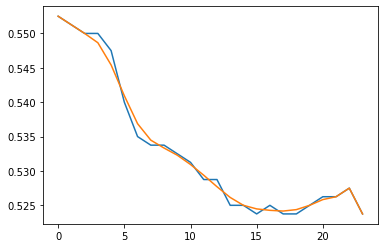

0.5329166666666667
12 12


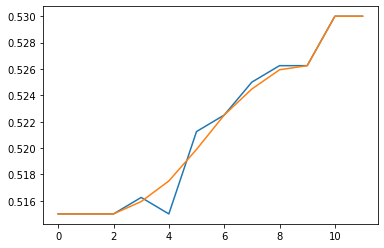

0.5214583333333334
33 33


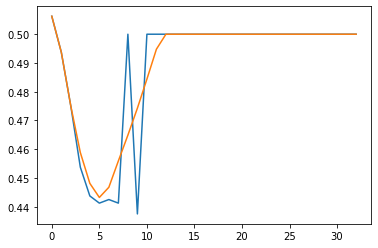

0.4889393939393939
16 16


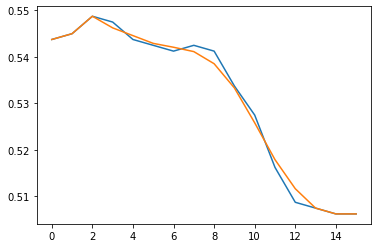

0.53140625
33 33


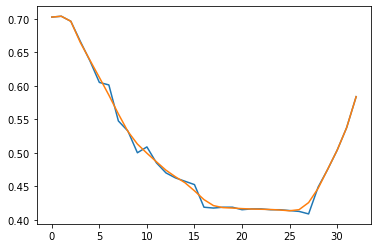

0.5019318181818182
18 18


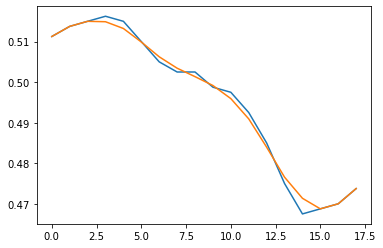

0.49555555555555564
44 44


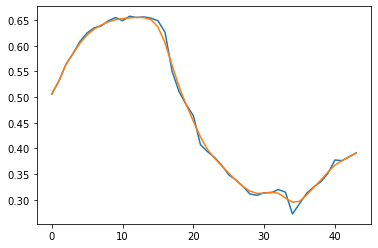

0.4640340909090909
37 37


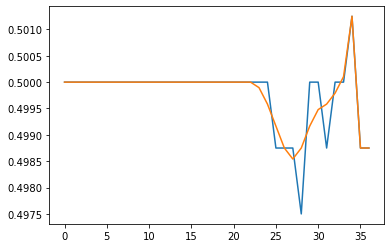

0.49976351351351356
27 27


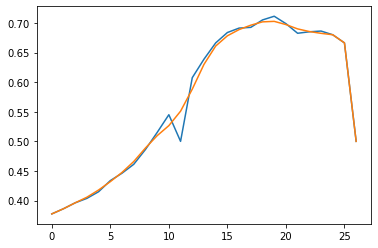

0.5689351851851852


In [68]:
videos = load_videos("templates/taobao-102", 5)
for video in videos:
    smooth_rois = get_smooth_rois(video)
    print(get_mean_roi(video))

In [70]:
type(math.floor(1.2))

int

In [85]:
a = np.array([
    [1, 1.41421356],
    [1.41421356, 2]
])
b = a.T

In [87]:
np.mean(np.sqrt((a*a + b*b)))

2.06066017010179

In [88]:
np.sqrt((a*a + b*b))

array([[1.41421356, 2.        ],
       [2.        , 2.82842712]])

In [92]:
video1 = videos[0]
video2 = videos[1]

In [154]:
calc_video_min_flow_diff(video1, video2)

(9.885652690098203, 4, True)

In [111]:
import time
start = time.time()
videos1 = load_videos("templates/taobao-0", 5)
videos2 = load_videos("templates/taobao-182", 5)
video1 = videos1[0]
video2 = videos2[0]
calc_video_min_flow_diff(video1, video2)
end = time.time()
print(end - start)

0.07881045341491699


In [119]:
view_group = {
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 2,
    6: 3,
    7: 3,
    8: 3,
    9: 5
}
direction_group = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 6,
    6: 8
}


def get_video_view(video):
    views = [view_group[frame.view] for frame in video.frames]
    return get_feature_mode(views)


def get_video_direction(video):
    directions = [direction_group[frame.direction] for frame in video.frames]
    return get_feature_mode(directions)


def get_feature_mode(values):
    counts = np.bincount(values)
    return np.argmax(counts)

get_feature_mode([1,1,2,2,3,3,4,4,4])

4

In [168]:
import os
import pickle


def load_videos(folder, version):
    path = os.path.join(folder, 'videos-v{}.pkl'.format(version))
    with open(path, 'rb') as f:
        return pickle.load(f)
    raise IOError('No Video Data File', folder)

def save_match_results(results, name):
    folder = 'matchs'
    path = os.path.join(folder, '{}.pkl'.format(name))
    f = open(path, 'wb')
    pickle.dump(results, f)
    f.close()

def load_all_videos():
    templates_folder = 'templates'
    tempaltes = os.listdir(templates_folder)
    tempaltes = [folder for folder in tempaltes
                 if os.path.isdir(os.path.join(templates_folder, folder))]
    tempaltes = sorted(tempaltes, key=lambda f: int(f.split('-')[-1]))
    videos = []
    for template in tempaltes:
        folder_path = os.path.join(templates_folder, template)
        t_videos = load_videos(folder_path, 5)
        videos.extend(t_videos)
    return videos

In [131]:
def get_video_name(video):
    temp = video.path.split("\\")
    return temp[1] + " " + temp[-1]

In [144]:
all_videos = load_all_videos()

In [145]:
print(len(all_videos))

6672


In [ ]:
import progressbar

# all_results = []
for v1 in all_videos:
    v1_match = []
    print(get_video_name(v1))
    if len(v1.frames) <= 2:
        print("Not enough frames.")
        continue
    v1_view = get_video_view(v1)
    v1_direct = get_video_direction(v1)
    p = progressbar.ProgressBar()
    p.start(len(all_videos))
    for vi, v2 in enumerate(all_videos):
        p.update(vi+1)
        if len(v2.frames) <= 2:
            continue
        if v1 == v2:
            continue
        v2_view = get_video_view(v2)
        v2_direct = get_video_direction(v2)
        if abs(v1_view - v2_view) > 1 and abs(v1_direct - v2_direct) > 1:
            continue
        diff, index, swap = calc_video_min_flow_diff(v1, v2)
        min_length = min(len(v1.frames), len(v2.frames))
        diff /= min_length
        v1_match.append((get_video_name(v2), diff, index, swap))
    v1_match = sorted(v1_match, key=lambda result: result[1])
    v1_match = v1_match[:600]
    save_match_results(v1_match, get_video_name(v1))
#     all_results.append((v1, v1_match))
#     for vm in v1_match[:10]:
#         print(vm[1], get_video_name(vm[0]), vm[2], vm[3])
    p.finish()

  0% (33 of 6672) |                      | Elapsed Time: 0:00:00 ETA:   0:00:42

taobao-0 00.mp4


100% (6672 of 6672) |####################| Elapsed Time: 0:00:41 Time:  0:00:41
  0% (26 of 6672) |                      | Elapsed Time: 0:00:00 ETA:   0:00:27

taobao-0 01.mp4


100% (6672 of 6672) |####################| Elapsed Time: 0:00:35 Time:  0:00:35
  0% (18 of 6672) |                      | Elapsed Time: 0:00:00 ETA:   0:00:37

taobao-0 02.mp4


100% (6672 of 6672) |####################| Elapsed Time: 0:00:43 Time:  0:00:43
  0% (31 of 6672) |                      | Elapsed Time: 0:00:00 ETA:   0:00:22

taobao-0 03.mp4


100% (6672 of 6672) |####################| Elapsed Time: 0:00:26 Time:  0:00:26


taobao-0 04.mp4


100% (6672 of 6672) |####################| Elapsed Time: 0:00:20 Time:  0:00:20


taobao-0 05.mp4


100% (6672 of 6672) |####################| Elapsed Time: 0:00:20 Time:  0:00:20
  0% (33 of 6672) |                      | Elapsed Time: 0:00:00 ETA:   0:00:21

taobao-0 06.mp4


 73% (4899 of 6672) |##############      | Elapsed Time: 0:00:17 ETA:   0:00:03

In [166]:
a = [1, 2, 3, 4, 5, 6]
a[:100]

[1, 2, 3, 4, 5, 6]

In [171]:
video1.name

'00.mp4'

In [1]:
def load_results(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [10]:
import pickle

vi = '0'
si = '03'
path = 'matches/taobao-{} {}.mp4.pkl'.format(vi, si)
res = load_results(path)
res

[('taobao-313 1.mp4', 0.2667935352576406, 43, True),
 ('taobao-390 04.mp4', 0.2943313347665887, 0, True),
 ('taobao-697 0.mp4', 0.3008850982314662, 3, True),
 ('taobao-321 5.mp4', 0.30392911434173586, 30, True),
 ('taobao-318 1.mp4', 0.3047834641055057, 8, True),
 ('taobao-781 1.mp4', 0.306875016814784, 17, True),
 ('taobao-699 6.mp4', 0.30804453335310283, 1, True),
 ('taobao-325 10.mp4', 0.30813376527083547, 6, True),
 ('taobao-237 6.mp4', 0.310104805544803, 1, True),
 ('taobao-92 5.mp4', 0.3107514136715939, 16, True),
 ('taobao-696 7.mp4', 0.311396470822786, 0, True),
 ('taobao-184 5.mp4', 0.3115894556045532, 0, True),
 ('taobao-306 13.mp4', 0.3120311837447317, 5, True),
 ('taobao-168 8.mp4', 0.31249840259552003, 11, True),
 ('taobao-146 0.mp4', 0.31259585430747583, 7, True),
 ('taobao-698 0.mp4', 0.3133032667009454, 1, True),
 ('taobao-319 4.mp4', 0.313432650817068, 13, True),
 ('taobao-92 7.mp4', 0.31371915465907046, 5, True),
 ('taobao-318 0.mp4', 0.31396919049714744, 0, True),
 (